In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib as mpl
import os
from matplotlib.lines import Line2D
from collections import Counter
import math
from sklearn.decomposition import PCA
from aging.behavior.syllables import relabel_by_usage
from tqdm import tqdm
%matplotlib inline
import warnings
warnings.simplefilter('ignore')
import random
import scipy
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
%matplotlib inline
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import MinMaxScaler

In [2]:
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from matplotlib.gridspec import GridSpec
from collections import defaultdict
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import ShuffleSplit
from sklearn.svm import LinearSVC
from sklearn.model_selection import GroupKFold, LeaveOneGroupOut, LeaveOneOut, KFold
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, r2_score, confusion_matrix
from sklearn.neighbors import KNeighborsRegressor

In [3]:
format_plots()
#format_pizza_plots()

In [4]:
def mm_norm_col(column):
    return (column - column.min()) / (column.max() - column.min())

In [5]:
from matplotlib.colors import LinearSegmentedColormap
# Define the color map
colors = ['#d94801','white','#008C8D']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmmf=custom_cmap

colors = ['#dadaeb','#6a51a3']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cma=custom_cmap

colors = ['white','gray']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cma=custom_cmap

colors = ['#ccece6','#99d8c9','#66c2a4','#41ae76','#238b45','#006d2c']
cml = sns.blend_palette(colors, n_colors=256, as_cmap=True)

# Define the color map
colors = ['#fee6ce','#d94801']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmf=custom_cmap

colors = ['#c7eae5','#008C8D']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap

In [6]:
## arrange data
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)

male_df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/ontogeny_males_raw_usage_matrix_v00.parquet').astype(float)
male_df = male_df[keep_syllables]
m_df= male_df.groupby(['age','uuid']).mean()


## arrange data for females
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)

female_df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/ontogeny_females_raw_usage_matrix_v00.parquet').astype(float)
female_df = female_df[keep_syllables]


# for female:
f_df= female_df.groupby(['age','uuid']).mean()
# Update age value to 52 for rows with uuid in the list
uuids = ['f1d5dce5-f5cf-4b03-b07d-d9b8c1f034b0','6fa50ac7-6d49-4ef9-9059-3d90bdd8c5d4',
         'e9e05da8-fc59-40f3-a9c8-f57c492c6141','327e7fa1-2237-43d2-b25f-c1801912df33',
        '242bee8e-0ee7-45e7-8a13-678836a4cddb','552ec70f-0676-4471-8ab0-403e1fcf43e3','d6f254af-d55a-427a-96e0-c452a233cbe2']
f_df.reset_index(inplace=True)

age_mapping = {
    93: 94,
    95: 94,
    97: 98,
    98: 98,
    102: 98,
    103: 105,
    105: 105,
    107: 105
}

f_df['age'] = f_df['age'].map(age_mapping).fillna(f_df['age'])
f_df.loc[f_df['uuid'].isin(uuids), 'age'] = 52
# Set the index back
f_df.set_index(['age', 'uuid'], inplace=True)
f_df=f_df.query('age<127')

In [7]:
# use only common ages
f_ages = f_df.index.get_level_values('age').unique().to_numpy()
m_ages = m_df.index.get_level_values('age').unique().to_numpy()
cages = list(np.intersect1d(f_ages,m_ages))

m_data = m_df.loc[m_df.index.get_level_values('age').isin(cages)]
m_data['sex'] = 'm'
m_data.set_index('sex',inplace=True,append=True)

f_data = f_df.loc[f_df.index.get_level_values('age').isin(cages)]
f_data['sex'] = 'f'
f_data.set_index('sex',inplace=True,append=True)
data=pd.concat([m_data,f_data])

In [8]:
#average and normalize male
avg_m_df = m_data.groupby(['age']).mean()
# normalize the data
m_norm = mm_norm_col(m_data)
avg_m_norm = mm_norm_col(avg_m_df)

#average and normalize female
avg_f_df = f_data.groupby(['age']).mean()
# normalize the data
f_norm = mm_norm_col(f_data)
avg_f_norm = mm_norm_col(avg_f_df)

data=pd.concat([m_data,f_data])

In [9]:
# choose a model for decoder
df=data.copy()
clf = svm.SVC(kernel='linear') 
# choose cross validation scheme
cv = LeaveOneOut()
#number of iterations for shuffle
it=100

In [10]:
age2=[]
acc=[]
n=10
for i in tqdm(range(it)):
    temp = df.groupby(level=['age', 'sex']).apply(lambda x: x.sample(n=n,replace=False, random_state=i)).reset_index(level=[0, 1],drop=True)
    for age,_df in enumerate(temp.groupby('age')):
        age2.append(_df[0])
        x = _df[1].to_numpy()
        x = np.log(x + 1e-6)
        y=_df[1].index.get_level_values('sex')
        acc.append(np.mean(cross_val_score(clf, x, y, cv=cv, n_jobs=-1)))
    

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:55<00:00,  1.81it/s]


In [11]:
sh_ages=[]
sh_acc=[]

for i in tqdm(range(it)):
    temp = df.groupby(level=['age', 'sex']).apply(lambda x: x.sample(n=n,replace=False, random_state=i)).reset_index(level=[0, 1],drop=True)
    # Extract the MultiIndex levels
    index_df = temp.index.to_frame()
    index_df['sex'] = index_df['sex'].sample(frac=1, random_state=42).values
    # Create a new MultiIndex with the shuffled 'sex'
    temp.index = pd.MultiIndex.from_frame(index_df)
    for age,_df in enumerate(temp.groupby('age')):
        sh_ages.append(_df[0])
        x = _df[1].to_numpy()
        x = np.log(x + 1e-6)
        y=_df[1].index.get_level_values('sex')
        sh_acc.append(np.mean(cross_val_score(clf, x, y, cv=cv, n_jobs=-1)))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:52<00:00,  1.90it/s]


In [12]:
# create df for plotting
df_sh = pd.DataFrame()
df_sh['acc']=sh_acc
df_sh['ages'] = sh_ages

df = pd.DataFrame()
df['acc']=acc
df['ages'] = age2

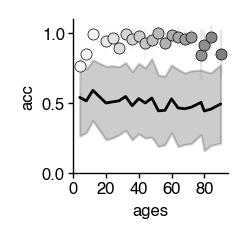

In [13]:
format_plots()
fig, ax = plt.subplots(figsize=(1, 1))
#sns.violinplot(data=df_sh, x="ages", y="acc", ax=ax, color='gray')
sns.lineplot(data=df_sh, x="ages", y="acc", ax=ax, color='black', estimator='mean', errorbar=('sd', 2))
sns.lineplot (data=df, x='ages', y='acc', 
              markers=True, 
              marker='o',
              markersize=4,
              palette = cma,
              hue='ages',
              linestyle='-',
              markeredgecolor='black', 
              markeredgewidth=0.25,
              estimator='mean', 
              errorbar=('sd',2),
            legend=False)
plt.ylim([0.0,1.1])
plt.legend([],[], frameon=False)
# Set custom x-ticks
plt.xticks([0, 20, 40, 60, 80])
sns.despine()


In [14]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig1"/ 'fvm_sex_decoder_svm_sd.pdf', bbox_inches='tight')